In [1]:
import pandas as pd
from pandas_datareader.data import DataReader
pd.set_option('display.max_rows', None)
import numpy as np
import pingouin as pg

import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy
from scipy import signal
import scipy.stats as st
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.weightstats import ttest_ind
from tqdm.notebook import tqdm
from datetime import timedelta
import math
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
start_date = '2014-12-30'
end_date = '2022-01-09'
method = "Adj Close"
stock_ex = ['^GSPC', 'IMOEX.ME']

In [3]:
def get_index_data(start_date, end_date, method=method, i=0):
    spx_index = DataReader(stock_ex[i], 'yahoo', start_date, end_date)
    spx_returns = spx_index[method].pct_change().dropna()
    return spx_index, spx_returns

In [4]:
spx_index, spx_returns = get_index_data(start_date, end_date, i=0)

In [5]:
"""
spx_index.to_csv('moex_index.csv')
spx_returns.to_csv('moex_returns.csv')
"""

"\nspx_index.to_csv('moex_index.csv')\nspx_returns.to_csv('moex_returns.csv')\n"

<AxesSubplot:xlabel='Date'>

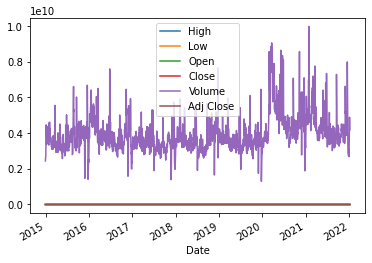

In [6]:
spx_index.plot()

In [7]:
spx_returns.head()

Date
2014-12-31   -0.010311
2015-01-02   -0.000340
2015-01-05   -0.018278
2015-01-06   -0.008893
2015-01-07    0.011630
Name: Adj Close, dtype: float64

In [8]:
# dictionary = spx_returns.to_dict()

In [9]:
# dictionary

In [10]:
# for i in dictionary:
#     if (dictionary[i + 1] - i).days > 1:
#         missed_day = i + timedelta(days = 1)
#         missed_return = dictionary[i]
#         dict2 = {missed_day: missed_return}
#         dictionary.update(dict2)

In [11]:
# (spx_returns.index[1] - spx_returns.index[0]).days

In [12]:
# for i in range(len(spx_returns)):
#     if (spx_returns.index[i + 1] - spx_returns.index[i]).days > 1:
#         missed_day = spx_returns.index[i] + timedelta(days = 1)
#         missed_return = spx_returns[i]
#         spx_returns
#         spx_returns.index.append(missed_day)
#         spx_returns[missed_day] = pd.Series(spx_returns[i])

## Normality test

<function matplotlib.pyplot.show(close=None, block=None)>

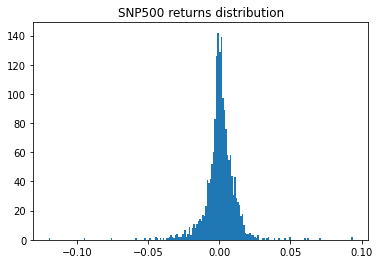

In [13]:
plt.title(f'SNP500 returns distribution')
plt.hist(spx_returns, bins=200, label='returns')
plt.show

In [14]:
rng = np.random.default_rng()
k2, p = st.normaltest(spx_returns)
alpha = 0.05
print("p = {:g}".format(p))
if p > alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 7.29083e-121
The null hypothesis cannot be rejected


# Detection algorithms

## Confidence intervals

In [15]:
def mean_comparison_confint(data, n=10, alpha=0.9):
    """ Function compares value of return at exact date with mean of either period of n days before this date
    or n days before and n days after. If by t-test it is significantly different, the date is considered as change point. 
    Also returns p-value, arguments are n days before the date and n days after.
    """
    cols = ['p-value', 'conf_2n_lower', 'conf_2n_upper', 'conf_nprev_lower', 'conf_nprev_upper']
    df = pd.DataFrame(spx_returns)
    for new_column in cols:
        df[new_column] = np.nan
    
    for i in range(n, len(df)):
        n_prev = spx_returns[i - n:i - 1]
        n_post = spx_returns[i:i + (n - 1)]
        n_concat = pd.concat([n_prev, n_post])
        
        # check whether the date statistically differs from the 2n interval mean
        conf_2n = st.t.interval(alpha=alpha, df=len(n_concat)-1, loc=np.mean(n_concat), scale=np.std(n_concat))
        
        # check whether the date statistically differs from n previous days mean
        conf_prev = st.t.interval(alpha=alpha, df=len(n_prev)-1, loc=np.mean(n_prev), scale=np.std(n_prev))
        
        # get p-values
        results = ttest_ind(n_prev, n_post)
        
        df.iloc[i, list(df.columns).index('p-value')] = results[1].item(0)
        df.iloc[i, list(df.columns).index('conf_nprev_lower')] = conf_prev[0]
        df.iloc[i, list(df.columns).index('conf_nprev_upper')] = conf_prev[1]
        df.iloc[i, list(df.columns).index('conf_2n_lower')] = conf_2n[0]
        df.iloc[i, list(df.columns).index('conf_2n_upper')] = conf_2n[1]
    
    df = df[n:]
    
    # dataframe with info about confidence intervals
    df_conf_ints = df.drop('p-value', axis=1)
    
    # dataframe with p-values
    filter_list = ['conf_nprev', 'conf_2n']
    df_p_value = df.copy()
    for item in filter_list:
        df_p_value = df_p_value.drop(df.filter(regex=item).columns, axis=1)
        
    return df, df_conf_ints, df_p_value

In [16]:
statistical_info, confidence_intervals_for_mean, p_values = mean_comparison_confint(data=spx_returns)

In [17]:
statistical_info.head()

,Adj Close,p-value,conf_2n_lower,conf_2n_upper,conf_nprev_lower,conf_nprev_upper
Date,,,,,,
2015-01-15,-0.009248,0.625985,-0.020013,0.016518,-0.022977,0.016893
2015-01-16,0.013424,0.426985,-0.018647,0.017738,-0.022015,0.016930
2015-01-20,0.001550,0.671402,-0.020482,0.015648,-0.023311,0.016247
2015-01-21,0.004732,0.996541,-0.018623,0.018580,-0.019381,0.019361
2015-01-22,0.015270,0.984854,-0.017896,0.020091,-0.017321,0.019622


In [18]:
def confidence_within_2n_days(data, n=10):
    """ Working with conf_2n values. If the return value is less than a lower boundary or 
    greater than a higher boundary, it is an anomaly.
    """
    analysis_conf_2n = pd.DataFrame(columns=['Date'])
    data = data.reset_index(drop=False)
    
    # setting variables for column indeces
    date_col_index = list(data.columns).index('Date')
    return_col_index = 1
    lower_bound_col_index = list(data.columns).index('conf_2n_lower')
    upper_bound_col_index = list(data.columns).index('conf_2n_upper')
    
    # comparing actual values with the boundaries
    for i in range(len(data)):
        if data.iloc[i, return_col_index] <= data.iloc[i, lower_bound_col_index]:
            new_row = data.iloc[i, date_col_index]
            analysis_conf_2n.loc[i] = new_row
        elif data.iloc[i, return_col_index] >= data.iloc[i, upper_bound_col_index]:
            new_row = data.iloc[i, date_col_index]
            analysis_conf_2n.loc[i] = new_row 
        else:
            pass
    return analysis_conf_2n

In [19]:
print(f"Number of anomalies detected: {confidence_within_2n_days(statistical_info).count()}")
anomalies_2n = confidence_within_2n_days(statistical_info)
# anomalies_2n

Number of anomalies detected: Date    153
dtype: int64


In [20]:
def confidence_after_n(data, n=10):
    """ Working with conf_after_n values. If the return value is less than a lower boundary or 
    greater than a higher boundary, it is an anomaly.
    """
    analysis_conf_after_n = pd.DataFrame(columns=['Date'])
    data = data.reset_index(drop=False)
    
    # setting variables for column indeces
    date_col_index = list(data.columns).index('Date')
    return_col_index = 1
    lower_bound_col_index = list(data.columns).index('conf_nprev_lower')
    upper_bound_col_index = list(data.columns).index('conf_nprev_upper')
    
    # comparing actual values with the boundaries
    for i in range(len(data)):
        if data.iloc[i, return_col_index] <= data.iloc[i, lower_bound_col_index]:
            new_row = data.iloc[i, date_col_index]
            analysis_conf_after_n.loc[i] = new_row
        elif data.iloc[i, return_col_index] >= data.iloc[i, upper_bound_col_index]:
            new_row = data.iloc[i, date_col_index]
            analysis_conf_after_n.loc[i] = new_row    
    
    return analysis_conf_after_n

In [21]:
anomalies_after_n = confidence_after_n(statistical_info)
print(f"Number of anomalies detected: {anomalies_after_n.count()}")
# anomalies_after_n

Number of anomalies detected: Date    248
dtype: int64


## Confidence interval dates with p_values < 0.1

In [22]:
# handwritten intersection algorithm
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [23]:
def compare_means(data, data_anomalies, p_val=0.1, n=10):
    """ Evaluate whether two intervals means significantly differ. Looking at p-value column. If actual value is lower
    than established one, difference between two intervals is significant.
    
    Making dates succeeded in p-value test a mask. Masking results from analysis_conf_2n because those 
    cannot be always accurate (the function may return few days consiquently)
    """
    data = data.reset_index(drop=False)
    mean_anom = data[data['p-value'] <= p_val]
    
#     set_mean_anom, set_conf_2n = set(mean_anom['Date']), set(data_anomalies['Date'])
#     change_point = pd.DataFrame(list(set_mean_anom.intersection(set_conf_2n)), columns=[str(f"{n} days CP")])
    change_point = pd.DataFrame(intersection(list(mean_anom['Date']), list(data_anomalies['Date'])), columns=['Date'])
    
    printing = f"number of dates with significant influence over next {n} days: {len(change_point)}"
    return mean_anom, printing, change_point

In [24]:
# algorithm compare_means for confidence_within_2n_days

mean_anom, printing, change_point = compare_means(data=statistical_info, data_anomalies=anomalies_2n)
print(printing)
change_point

number of dates with significant influence over next 10 days: 12


,Date
0,2015-08-26
1,2016-11-07
2,2017-03-02
3,2017-04-17
4,2018-11-12
5,2018-12-26
6,2019-03-11
7,2019-06-04
8,2020-09-03
9,2021-03-26


In [25]:
# algorithm compare_means for confidence_after_n

mean_anom, printing, change_point = compare_means(data=statistical_info, data_anomalies=anomalies_after_n)
print(printing)
# change_point

number of dates with significant influence over next 10 days: 29


In [26]:
print(f"number of anomalies_2n: {len(anomalies_2n['Date'])}, number of anomalies_after_n: {len(anomalies_after_n['Date'])}")
print(f"intersected dates: {pd.DataFrame(intersection(list(anomalies_2n['Date']), list(anomalies_after_n['Date']))).iloc[:,0].count()}")

number of anomalies_2n: 153, number of anomalies_after_n: 248
intersected dates: 132


In [27]:
# filling dates skipped due to holidays 
idx = pd.date_range(start_date, end_date)
spx_restored_dates = spx_returns.reindex(list(idx), fill_value=0)
spx_restored_dates.head()

Date
2014-12-30    0.000000
2014-12-31   -0.010311
2015-01-01    0.000000
2015-01-02   -0.000340
2015-01-03    0.000000
Name: Adj Close, dtype: float64

In [28]:
"""
# running algorithms through cycle

N = [5, 10, 15, 20]
signif_influence = pd.DataFrame(0, index=np.arange(len(spx_returns)), columns=['0'])
for n in tqdm(N):
    # setting variables
    statistical_info, confidence_intervals_for_mean, p_values = mean_comparison_confint(data=spx_returns, n=n)
    anomalies_2n = confidence_within_2n_days(data=statistical_info, n=n)
    anomalies_after_n = confidence_after_n(data=statistical_info, n=n)
    mean_anom, printing, change_point = compare_means(data=statistical_info, data_anomalies=anomalies_2n, n=n)
    
    # dropping index
#     df_signif_influence = signif_influence.reset_index(drop=True)
#     df_anomalies_2n = anomalies_2n['Date'].rename(f"within_2_{n}_days").reset_index(drop=True)
#     df_mean_anom = mean_anom['Date'].rename(f"signif_2_{n}_days").reset_index(drop=True)
#     df_anomalies_after_n = anomalies_after_n['Date'].rename(f"after_{n}days").reset_index(drop=True)
    
    df_signif_influence = signif_influence.reindex(list(range(0, len(spx_returns))),fill_value=0)
    skipped_rows = pd.DataFrame(0, index=np.arange(n), columns=['0'])
    df_anomalies_2n = anomalies_2n['Date'].rename(f"within_2_{n}_days")
    print(df_anomalies_2n)
    df_anomalies_2n = df_anomalies_2n.reindex(list(range(0, len(spx_returns))),fill_value=0)
    print(df_anomalies_2n)
    df_anomalies_2n = pd.concat([skipped_rows['0'].rename(f"within_2_{n}_days"), df_anomalies_2n], ignore_index=True)
#     print(df_anomalies_2n)
    df_mean_anom = mean_anom['Date'].rename(f"signif_2_{n}_days").reindex(list(range(0, len(spx_returns))),fill_value=0)
    df_mean_anom = pd.concat([skipped_rows['0'].rename(f"signif_2_{n}_days"), df_mean_anom], ignore_index=True)
    df_anomalies_after_n = anomalies_after_n['Date'].rename(f"after_{n}days").reindex(list(range(0, len(spx_returns))),fill_value=0)
    df_anomalies_after_n = pd.concat([skipped_rows['0'].rename(f"after_{n}days"), df_anomalies_after_n], ignore_index=True)
    
    signif_influence = pd.concat([df_signif_influence, df_anomalies_2n, df_mean_anom, df_anomalies_after_n], axis=1, ignore_index=False)
    print(printing, change_point)
"""

'\n# running algorithms through cycle\n\nN = [5, 10, 15, 20]\nsignif_influence = pd.DataFrame(0, index=np.arange(len(spx_returns)), columns=[\'0\'])\nfor n in tqdm(N):\n    # setting variables\n    statistical_info, confidence_intervals_for_mean, p_values = mean_comparison_confint(data=spx_returns, n=n)\n    anomalies_2n = confidence_within_2n_days(data=statistical_info, n=n)\n    anomalies_after_n = confidence_after_n(data=statistical_info, n=n)\n    mean_anom, printing, change_point = compare_means(data=statistical_info, data_anomalies=anomalies_2n, n=n)\n    \n    # dropping index\n#     df_signif_influence = signif_influence.reset_index(drop=True)\n#     df_anomalies_2n = anomalies_2n[\'Date\'].rename(f"within_2_{n}_days").reset_index(drop=True)\n#     df_mean_anom = mean_anom[\'Date\'].rename(f"signif_2_{n}_days").reset_index(drop=True)\n#     df_anomalies_after_n = anomalies_after_n[\'Date\'].rename(f"after_{n}days").reset_index(drop=True)\n    \n    df_signif_influence = signif_

In [29]:
N = [5, 10, 15, 20]
signif_influence = pd.DataFrame(0, index=spx_returns.index, columns=['0'])
target = pd.DataFrame(0, index=spx_restored_dates.index, columns=['0'])
change_points_mean = pd.DataFrame(0, index=spx_restored_dates.index, columns=['0'])

In [30]:
# running algorithms through cycle

for n in tqdm(N):
    # setting variables
    statistical_info, confidence_intervals_for_mean, p_values = mean_comparison_confint(data=spx_index[method], n=n)
    anomalies_2n = confidence_within_2n_days(data=statistical_info, n=n)
    anomalies_after_n = confidence_after_n(data=statistical_info, n=n)
    mean_anom, printing, change_point = compare_means(data=statistical_info, data_anomalies=anomalies_2n, n=n)
    
    # dropping index
#     df_signif_influence = signif_influence.reset_index(drop=True)
#     df_anomalies_2n = anomalies_2n['Date'].rename(f"within_2_{n}_days").reset_index(drop=True)
#     df_mean_anom = mean_anom['Date'].rename(f"signif_2_{n}_days").reset_index(drop=True)
#     df_anomalies_after_n = anomalies_after_n['Date'].rename(f"after_{n}days").reset_index(drop=True)
    
    df_signif_influence = signif_influence.reindex(list(range(0, len(spx_returns))),fill_value=0)
    
#     skipped_rows = pd.DataFrame(0, index=np.arange(n), columns=['0'])
    
    df_anomalies_2n = pd.DataFrame(anomalies_2n['Date'])
    df_anomalies_2n[f"within_2_{n}_days"] = 1
#     print(df_anomalies_2n)
    df_index_anomalies_2n = df_anomalies_2n.set_index('Date')
#     print(df_index_anomalies_2n)
    df_index_anomalies_2n = df_index_anomalies_2n.reindex(idx, fill_value=0)
#     target[f"within_2_{n}_days"] = df_index_anomalies_2n
#     print(target)
#     print(df_index_anomalies_2n)
#     print(df_index)
#     df_anomalies_2n = df_anomalies_2n.reindex(list(range(0, len(spx_returns))),fill_value=0)
#     print(df_anomalies_2n)
#     df_anomalies_2n = pd.concat([skipped_rows['0'].rename(f"within_2_{n}_days"), df_anomalies_2n], ignore_index=True)
#     print(df_anomalies_2n)
    
    df_mean_anom = pd.DataFrame(mean_anom['Date'])
    df_mean_anom[f"signif_2_{n}_days"] = 1
    df_index_mean_anom = df_mean_anom.set_index('Date')
    df_index_mean_anom = df_index_mean_anom.reindex(idx, fill_value=0)
#     target[f"signif_2_{n}_days"] = df_index_mean_anom
#     df_mean_anom = mean_anom['Date'].rename(f"signif_2_{n}_days")
#     df_index_mean_anom = df_mean_anom.reindex(df_anomalies_2n, fill_value=1)
#     df_index_mean_anom = df_index_mean_anom.reindex(idx, fill_value=0)
# #     df_mean_anom = df_mean_anom.reindex(list(range(0, len(spx_returns))),fill_value=0)
# #     df_mean_anom = pd.concat([skipped_rows['0'].rename(f"signif_2_{n}_days"), df_mean_anom], ignore_index=True)
    
    df_anomalies_after_n = pd.DataFrame(anomalies_after_n['Date'])
    df_anomalies_after_n[f"after_{n}days"] = 1
    df_index_anomalies_after_n = df_anomalies_after_n.set_index('Date')
    df_index_anomalies_after_n = df_index_anomalies_after_n.reindex(idx, fill_value=0)
#     target[f"after_{n}days"] = df_index_anomalies_after_n
#     df_anomalies_after_n = anomalies_after_n['Date'].rename(f"after_{n}days")
#     df_index_anomalies_after_n = df_anomalies_after_n.reindex(df_anomalies_2n, fill_value=1)
#     df_index_anomalies_after_n = df_index_anomalies_after_n.reindex(idx, fill_value=0)
# #     df_anomalies_after_n = df_anomalies_after_n.reindex(list(range(0, len(spx_returns))),fill_value=0)
# #     df_anomalies_after_n = pd.concat([skipped_rows['0'].rename(f"after_{n}days"), df_anomalies_after_n], ignore_index=True)
    
    df_change_point = change_point.copy()
    df_change_point[str(f"{n} days CP")] = 1
    df_index_change_point = df_change_point.set_index('Date')
    df_index_change_point = df_index_change_point.reindex(idx, fill_value=0)
    
#     signif_influence = pd.concat([df_signif_influence, df_anomalies_2n, df_mean_anom, df_anomalies_after_n], axis=1, ignore_index=False)
    target = pd.concat([target, df_index_anomalies_2n, df_index_mean_anom, df_index_anomalies_after_n], axis=1)
    change_points_mean = pd.concat([change_points_mean, df_index_change_point], axis=1)
#     print(target)
    print(printing, change_point)

  0%|          | 0/4 [00:00<?, ?it/s]

number of dates with significant influence over next 5 days: 7         Date
0 2015-07-28
1 2015-07-29
2 2016-11-07
3 2018-12-26
4 2019-03-11
5 2019-07-08
6 2021-06-21
number of dates with significant influence over next 10 days: 12          Date
0  2015-08-26
1  2016-11-07
2  2017-03-02
3  2017-04-17
4  2018-11-12
5  2018-12-26
6  2019-03-11
7  2019-06-04
8  2020-09-03
9  2021-03-26
10 2021-06-21
11 2022-01-05
number of dates with significant influence over next 15 days: 12          Date
0  2015-08-26
1  2015-08-27
2  2015-09-30
3  2016-11-07
4  2018-12-04
5  2018-12-26
6  2019-06-04
7  2019-10-04
8  2020-03-24
9  2020-09-03
10 2020-11-04
11 2021-06-21
number of dates with significant influence over next 20 days: 13          Date
0  2016-06-28
1  2016-06-29
2  2016-11-07
3  2017-03-01
4  2017-04-17
5  2017-12-29
6  2018-12-26
7  2019-01-04
8  2019-05-07
9  2019-06-04
10 2019-10-04
11 2020-03-24
12 2021-10-14


In [31]:
target = target.fillna(0)
target = target.drop(['0'], axis=1)

In [32]:
target.head()

,within_2_5_days,signif_2_5_days,after_5days,within_2_10_days,signif_2_10_days,after_10days,within_2_15_days,signif_2_15_days,after_15days,within_2_20_days,signif_2_20_days,after_20days
2014-12-30,0,0,0,0,0,0,0,0,0,0,0,0
2014-12-31,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-02,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-03,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
change_points_mean = change_points_mean.drop(['0'], axis=1)

In [34]:
print(change_points_mean.head())
print(change_points_mean[change_points_mean.iloc[:,:] != 0].count())

            5 days CP  10 days CP  15 days CP  20 days CP
2014-12-30          0           0           0           0
2014-12-31          0           0           0           0
2015-01-01          0           0           0           0
2015-01-02          0           0           0           0
2015-01-03          0           0           0           0
5 days CP      7
10 days CP    12
15 days CP    12
20 days CP    13
dtype: int64


### Algorithm that evaluates correct change points

it takes change_points_mean and pelt_analysis, and makes dates cp if pelt_analysis date is 5 days before or 
5 days after change_points_mean

In [35]:
change_points_mean['result'] = change_points_mean.T.sum()
change_points_mean['result_ones'] = 0
change_points_mean['result_ones'][change_points_mean['result'] != 0] = 1

In [36]:
# change_points_mean['result_ones'].sum()

In [49]:
cp_concat = pd.concat([change_points_mean['result_ones'], change_points_mean['result'], pelt_analysis], axis=1)
cp_concat['super_result'] = cp_concat.T.sum()
cp_concat['super_result'][cp_concat['super_result'] > 1].count()

28

In [50]:
cp_concat.head()

,result_ones,result,pelt,super_result
2014-12-30,0,0,1,1
2014-12-31,0,0,0,0
2015-01-01,0,0,0,0
2015-01-02,0,0,0,0
2015-01-03,0,0,0,0


In [51]:
"""
for i in range(len(cp_concat)):
    if cp_concat.iloc[i:i+5, 0].sum() > 1:
        continue
    else:
        if cp_concat.iloc[i, 0] == 1:
            for j in range(i-5, i+5):
                if cp_concat.iloc[j, 2] >= 1:
                    cp_concat.iloc[i, 2] = 0
                    break
                if cp_concat.iloc[j, 1] == 1:
                    cp_concat.iloc[i, 2] = 1
                    break
                else:
                    cp_concat.iloc[i, 2] = 0
        else:
            cp_concat.iloc[i, 2] = 0
            
"""

'\nfor i in range(len(cp_concat)):\n    if cp_concat.iloc[i:i+5, 0].sum() > 1:\n        continue\n    else:\n        if cp_concat.iloc[i, 0] == 1:\n            for j in range(i-5, i+5):\n                if cp_concat.iloc[j, 2] >= 1:\n                    cp_concat.iloc[i, 2] = 0\n                    break\n                if cp_concat.iloc[j, 1] == 1:\n                    cp_concat.iloc[i, 2] = 1\n                    break\n                else:\n                    cp_concat.iloc[i, 2] = 0\n        else:\n            cp_concat.iloc[i, 2] = 0\n            \n'

In [57]:
for i in range(len(cp_concat)):
    # if there are points after the date within the range of 5, go to the next point
    if cp_concat.iloc[i:i+5, 0].sum() > 1:
        cp_concat.iloc[i, 3] = 0
        continue
    # else - if the point is one in the neighbourhood
    else:
        # if more than one tests in mean_alg agrees
        if cp_concat.iloc[i, 1] > 1:
            cp_concat.iloc[i, 3] = 1
            continue
        # if there is a point in result_ones
        if cp_concat.iloc[i, 0] == 1:
            # for the neighbourhood of 5 points repeat
            for j in range(i-5, i+6):
                # if there is a result already in the column super_result, make result equal to zero (to delete duplicates)
                if cp_concat.iloc[j, 3] >= 1:
                    # except for the case when j = i
                    if j == i:
                        continue
                    cp_concat.iloc[i, 3] = 0
                    print(f"SuperResult duplicate {cp_concat.index[i]}")
                    break
                # if pelt agrees (results in 1), make result equal to 1
                if cp_concat.iloc[j, 2] == 1:
                    cp_concat.iloc[i, 3] = 1
                    print(f"Pelt agrees {cp_concat.index[i]}")
                    break
                # else (pelt disagrees) result is 0
                else:
                    cp_concat.iloc[i, 3] = 0
#             if cp_concat.iloc[i, 2] == 0:
#                 print(f"Conditions are not met {cp_concat.index[i]}")
        else:
            cp_concat.iloc[i, 3] = 0

Pelt agrees 2015-07-29 00:00:00
Pelt agrees 2016-06-29 00:00:00
Pelt agrees 2017-03-02 00:00:00
Pelt agrees 2017-12-29 00:00:00
Pelt agrees 2018-12-04 00:00:00
Pelt agrees 2019-01-04 00:00:00
Pelt agrees 2019-05-07 00:00:00
Pelt agrees 2020-11-04 00:00:00
Pelt agrees 2021-10-14 00:00:00
Pelt agrees 2022-01-05 00:00:00


In [55]:
print(cp_concat.head())

            result_ones  result  pelt  super_result
2014-12-30            0       0     1             0
2014-12-31            0       0     0             0
2015-01-01            0       0     0             0
2015-01-02            0       0     0             0
2015-01-03            0       0     0             0


In [58]:
cp_concat['super_result'][cp_concat['super_result'] >= 1].count()

19

In [ ]:
# cp_concat.to_csv('results/moex_cp.csv')

In [ ]:
# target.to_csv('results/moex_anomalies.csv')
# change_points_mean.to_csv('results/moex_change_points_mean.csv')

In [ ]:
"""
signif_influence = signif_influence.drop(['0'], axis=1)
"""

In [ ]:
"""
signif_influence = signif_influence.fillna(value='empty')
signif_influence.sort_index()
"""

In [ ]:
"""
signif_influence = pd.concat([signif_influence, spx_returns.reset_index(drop=False)['Date']], axis=1)
"""

In [ ]:
# signif_influence

In [ ]:
"""
conf_anomalies = signif_influence.copy()

for col in signif_influence.columns:
    for date in range(len(signif_influence)):
        date_column = list(signif_influence.columns).index('Date')
        actual_column = list(signif_influence.columns).index(col)
        if signif_influence[col].isin(signif_influence.iloc[date, date_column]) == True:
            conf_anomalies.iloc[date, actual_column] = 1
        else:
            conf_anomalies.iloc[date, actual_column] = 0
"""

## MMD

## 3 sigmas

In [ ]:
def sigma_method(data, sigma=3):
    mu = spx_returns.mean()
    dev = spx_returns.std()
    lower = mu - sigma * dev
    upper = mu + sigma * dev
    
    lower_anomalies = spx_returns[spx_returns <= lower]
    upper_anomalies = spx_returns[spx_returns >= upper]
    
    spx_statistical_anomalies = pd.concat([lower_anomalies, upper_anomalies])
    
    return spx_statistical_anomalies

In [ ]:
spx_statistical_anomalies = sigma_method(data=spx_returns, sigma=3)

In [ ]:
print(f"Number of statistical anomalies: {spx_statistical_anomalies.count()}")

In [ ]:
# setting zeros and ones to each date
df_spx_statistical_anomalies = pd.DataFrame(spx_statistical_anomalies)
df_spx_statistical_anomalies['3_sigma'] = 1
df_spx_statistical_anomalies = df_spx_statistical_anomalies.drop(method, axis=1)
df_spx_statistical_anomalies = df_spx_statistical_anomalies.reindex(idx, fill_value=0)
df_spx_statistical_anomalies.head()

In [ ]:
# df_spx_statistical_anomalies.to_csv('results/3_sigma_moex.csv')

## Tech_analysis

In [ ]:
# simple moving average

def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

In [ ]:
spx_index_bol = spx_index.copy()
spx_index_bol['SMA_20'] = sma(spx_index_bol[method], 5)
spx_index_bol['SMA_20'].head()

In [ ]:
# bollindger bands

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

In [ ]:
spx_index_bol['upper_bb'], spx_index_bol['lower_bb'] = bb(spx_index_bol[method], spx_index_bol['SMA_20'], 5)
spx_index_bol.tail()

In [ ]:
spx_index_bol['low_out'] = 0
spx_index_bol['high_out'] = 0
spx_index_bol.loc[spx_index_bol['Low'] < spx_index_bol['lower_bb'], 'low_out'] = 1
spx_index_bol.loc[spx_index_bol['High'] > spx_index_bol['upper_bb'], 'high_out'] = 1
spx_index_bol['outliers_from_tech'] = 0
spx_index_bol.loc[spx_index_bol['low_out'] == 1, 'outliers_from_tech'] = 1
spx_index_bol.loc[spx_index_bol['high_out'] == 1, 'outliers_from_tech'] = 1
spx_index_bol['outliers_from_tech'].value_counts()

In [ ]:
figure(figsize=(18, 10), dpi=80)
spx_index_bol[method].plot(label = 'CLOSE PRICES', color = 'skyblue')
spx_index_bol['upper_bb'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
spx_index_bol['SMA_20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
spx_index_bol['lower_bb'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('S&P500 BOLLINGER BANDS')
plt.show()

In [ ]:
# spx_index_bol[spx_index_bol['outliers_from_tech'] == 1].reset_index(drop=False)['Date'] outliers without boolean
outliers_tech = spx_index_bol['outliers_from_tech']
outliers_tech = outliers_tech.reindex(idx, fill_value=0)
outliers_tech.head()

In [ ]:
# outliers_tech.to_csv('results/outliers_tech_moex.csv')

## PELT

In [8]:
k = spx_index[method].reset_index(drop='True')
k = k.to_numpy()
k1 = spx_returns.reset_index(drop='True')
k1 = k1.to_numpy()

In [9]:
def normal_var(data, mean):
  
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    cumm = [0.0]
    cumm.extend(np.cumsum(np.power(np.abs(data - mean), 2)))

    def cost(s, t):
        dist = float(t - s)
        diff = cumm[t] - cumm[s]
        return dist * (np.log(2*math.pi)+np.log(diff/dist)+1)

    return cost

In [10]:
def normal_meanvar(data):

    data = np.hstack(([0.0], np.array(data)))

    cumm = np.cumsum(data)
    cumm_sq = np.cumsum([val**2 for val in data])

    def cost(s, t):
        ts_i = 1.0 / (t-s)
        mu = (cumm[t] - cumm[s]) * ts_i
        sig = (cumm_sq[t] - cumm_sq[s]) * ts_i - mu**2
        sig_i = 1.0 / sig
        return (t-s) * np.log(sig) + (cumm_sq[t] - cumm_sq[s]) * sig_i - 2*(cumm[t] - cumm[s])*mu*sig_i + ((t-s)*mu**2)*sig_i

    return cost

In [11]:
def find_min(arr, val=0.0):
    return min(arr) + val, np.argmin(arr)

In [12]:
def pelt(cost, length, pen=None):

    if pen is None:
        pen = 2 * np.log(length)

    F = np.zeros(length + 1)
    R = np.array([0], dtype=np.int64)
    candidates = np.zeros(length + 1, dtype=np.int64)

    F[0] = -pen

    for tstar in range(2, length + 1):
        cpt_cands = R
        seg_costs = np.zeros(len(cpt_cands))
        for i in range(0, len(cpt_cands)):
            seg_costs[i] = cost(cpt_cands[i], tstar)

        F_cost = F[cpt_cands] + seg_costs
        F[tstar], tau = find_min(F_cost, pen)
        candidates[tstar] = cpt_cands[tau]

        ineq_prune = [val < F[tstar] for val in F_cost]
        R = [cpt_cands[j] for j, val in enumerate(ineq_prune) if val]
        R.append(tstar - 1)
        R = np.array(R, dtype=np.int64)

    last = candidates[-1]
    changepoints = [last]
    while last > 0:
        last = candidates[last]
        changepoints.append(last)

    return sorted(changepoints)

In [16]:
import math

In [22]:
data_index = k
data_returns = k1
mean = 0.0
cost1 = normal_var(data_index, mean)
cost2 = normal_meanvar(data_index)
result1 = pelt(cost1, len(data_index))
result2 = pelt(cost2, len(data_index))
print(result1)
print(result2)

[0, 1, 679, 1474]
[0, 28, 30, 45, 68, 93, 100, 124, 133, 145, 147, 161, 194, 205, 238, 257, 278, 281, 285, 287, 293, 301, 306, 309, 312, 323, 326, 334, 353, 355, 365, 373, 378, 383, 385, 387, 403, 427, 432, 435, 449, 462, 464, 470, 474, 478, 489, 507, 521, 524, 528, 532, 536, 539, 545, 559, 564, 575, 583, 591, 593, 605, 609, 639, 642, 658, 660, 663, 666, 672, 679, 693, 697, 704, 713, 730, 734, 742, 747, 757, 760, 764, 770, 776, 779, 787, 812, 829, 832, 834, 843, 845, 862, 864, 873, 877, 885, 889, 897, 916, 920, 937, 943, 945, 948, 952, 956, 958, 960, 992, 998, 1000, 1012, 1019, 1028, 1036, 1039, 1052, 1054, 1069, 1071, 1076, 1078, 1084, 1094, 1098, 1117, 1123, 1133, 1154, 1178, 1182, 1187, 1189, 1191, 1196, 1206, 1215, 1219, 1223, 1229, 1232, 1247, 1249, 1252, 1265, 1270, 1275, 1283, 1295, 1307, 1325, 1327, 1338, 1354, 1360, 1387, 1394, 1407, 1414, 1422, 1432, 1453, 1466, 1474, 1476, 1487, 1491, 1509, 1516, 1524, 1529, 1533, 1535, 1549, 1558, 1575, 1579, 1581, 1610, 1618, 1633, 1637, 1

In [23]:
final = pd.DataFrame(0, index=spx_index.index, columns=['numbers', 'pelt'])
final['numbers'] = spx_index.reset_index(drop=True).index
for i in result2:
    final.loc[(final['numbers'] == i), 'pelt'] = 1

In [24]:
len(result2)

198

In [46]:
pelt_analysis = final['pelt']
pelt_analysis = pelt_analysis.reindex(idx, fill_value=0)
pelt_analysis.head()

2014-12-30    1
2014-12-31    0
2015-01-01    0
2015-01-02    0
2015-01-03    0
Freq: D, Name: pelt, dtype: int64

In [47]:
# pelt_analysis.to_csv('results/pelt_moex.csv')

In [48]:
# final['pelt'].to_csv('pelt.csv')